<a href="https://colab.research.google.com/github/naoya1110/pytorch_test_code/blob/main/CNN_with_CIFAR10_Dataset_Test_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN with CIFAR10 Dataset Test Code

## Introduction

This is a sample code for checking your PyTorch environment. We are going to use CIFAR10 dataset.

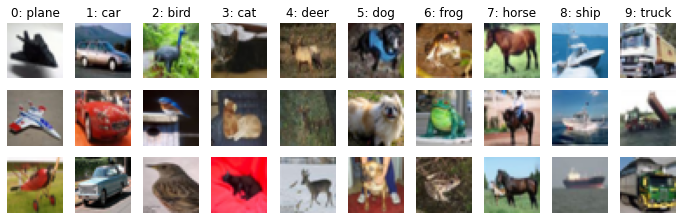

### GPU

We will need a GPU to train CNN models, so please make sure your runtime type is GPU, if you are using Google Colab.

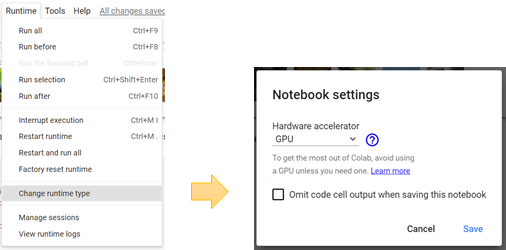

We can check if GPU (cuda) is available.

In [2]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


### General Packages

Then let's import some general Python packages.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Data Preparation

### CIFAR10 Dataset

CIFAR10 dataset can be loaded from `torchvision.datasets`. The `torchvision` package consists of several popular datasets, model architectures, and common image transformations for computer vision.

*   CIFAR10 https://www.cs.toronto.edu/~kriz/cifar.html
* torchvison https://pytorch.org/vision/stable/index.html

In [4]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root="cifar10", train=True, download=True)
test_dataset = CIFAR10(root="cifar10", train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


CIFAR10 datasets consists of 50,000 and 10,000 labeled images for training and testing respectively.

In [5]:
print("train dataset", len(train_dataset))
print("test dataset", len(test_dataset))

train dataset 50000
test dataset 10000


We can take individual set of image and label by indexing the dataset. The image data is in PIL format and this can be visualized with matplotlib.

* Pillow (PIL Fork) https://pillow.readthedocs.io/en/latest/handbook/index.html

type of image: <class 'PIL.Image.Image'>
size of image: (32, 32)
label: 6


Text(0.5, 1.0, '6')

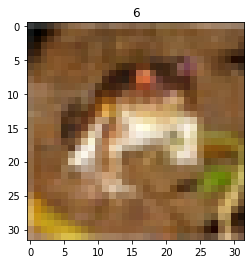

In [6]:
image, label = train_dataset[0]

print("type of image:", type(image))
print("size of image:", image.size)
print("label:", label)

plt.imshow(image)
plt.title(label)

The label number corresponds to 10 categories as shown below.

In [7]:
classnames = {0:"plane", 
              1:"car", 
              2:"bird", 
              3:"cat", 
              4:"deer",
              5:"dog", 
              6:"frog", 
              7:"horse",
              8:"ship",
              9:"truck"}

classnames

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### torch.tensor

In order to handle data with PyTorch, the data format needs to be in `torch.tensor`. We can get `torch.tensor` data by specifying the parameter of `transform=transforms.ToTensor()` when loading from `torchvision.datasets`.

In [8]:
from torchvision import transforms

train_dataset = CIFAR10(root="cifar10", train=True, download=False, transform=transforms.ToTensor())
test_dataset = CIFAR10(root="cifar10", train=False, download=False, transform=transforms.ToTensor())

Now the image data is in `torch.tensor`.

In [9]:
image, label = train_dataset[0]
print(type(image))

<class 'torch.Tensor'>


Note that one of the differences between `PIL` and `torch.tensor` image data is its order of data shape as shown below.

|  data format  |  shape  |
| :----: | :----: |
|  PIL  |  (32, 32, 3)  <br> (height, width, channel)|
|  torch.tensor  |  (3, 32, 32)  <br> (channel, height, width)|


The image data with the shape of (3, 32, 32) cannot be visualized using matplotlib.


TypeError: ignored

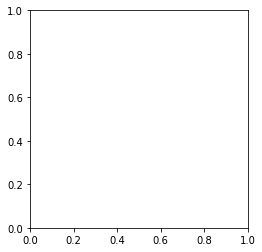

In [10]:
plt.imshow(image)    # this raises an error

### DataLoader

Anyway we create `DataLoader` objects for feeding data to a PyTorch model. This is exactly same as we did with Iris dataset.

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

That's it for data preparation!

## Model Building
We load ResNet18 pretrained model and modify the final layer to fit the 10-class classification task.

In [35]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 10)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training

### Loss Function

We use the cross-entropy loss as the loss function since this is a classification task.

In [32]:
loss_func = nn.CrossEntropyLoss()

### Optimizer

We use the Adam optimizer.

In [33]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### Training Loop
Now we train the model with CIFAR10 datasets. The training loop is almost same as we did last week, except for thet we load data on GPU.







In [39]:
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 10)
model = model.to(device)

loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer

epochs = 10

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    for x_batch, y_batch in tqdm(train_loader): # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        for x_batch, y_batch in tqdm(test_loader):   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #------------------------#

    train_accuracy = train_correct_count/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy.item())
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy.item())
    test_loss_list.append(test_loss)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-----------------------------
Epoch 1/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.657 Loss=1.011, Test: Accuracy=0.667 Loss=0.973
-----------------------------
Epoch 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.765 Loss=0.703, Test: Accuracy=0.766 Loss=0.684
-----------------------------
Epoch 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.809 Loss=0.574, Test: Accuracy=0.773 Loss=0.670
-----------------------------
Epoch 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.846 Loss=0.455, Test: Accuracy=0.784 Loss=0.655
-----------------------------
Epoch 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.876 Loss=0.369, Test: Accuracy=0.767 Loss=0.719
-----------------------------
Epoch 6/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.898 Loss=0.301, Test: Accuracy=0.795 Loss=0.637
-----------------------------
Epoch 7/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.921 Loss=0.231, Test: Accuracy=0.783 Loss=0.715
-----------------------------
Epoch 8/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.931 Loss=0.204, Test: Accuracy=0.803 Loss=0.682
-----------------------------
Epoch 9/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.948 Loss=0.155, Test: Accuracy=0.793 Loss=0.784
-----------------------------
Epoch 10/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.955 Loss=0.131, Test: Accuracy=0.788 Loss=0.796


### Learning Curves

Let's visualize the accuracy curves for train and test data.

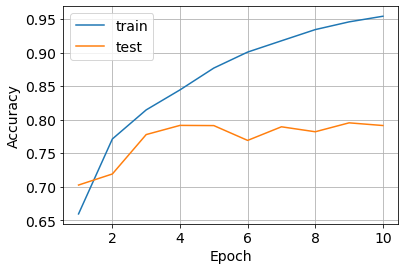

In [36]:
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

Also let's visualize the loss curves for train and test data.

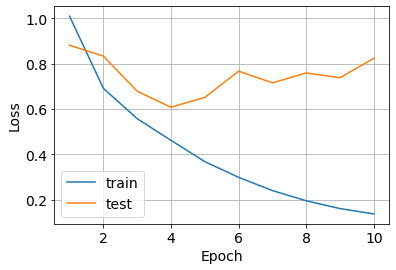

In [37]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# Evaluation

### Test Accuracy

We should check the accuracy of the model for all of the test data.

In [38]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode
    
    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

RuntimeError: ignored

### Confusion Matrix

Then let's check the confusion matrix.

Text(0.5, 1.0, 'confusion matrix')

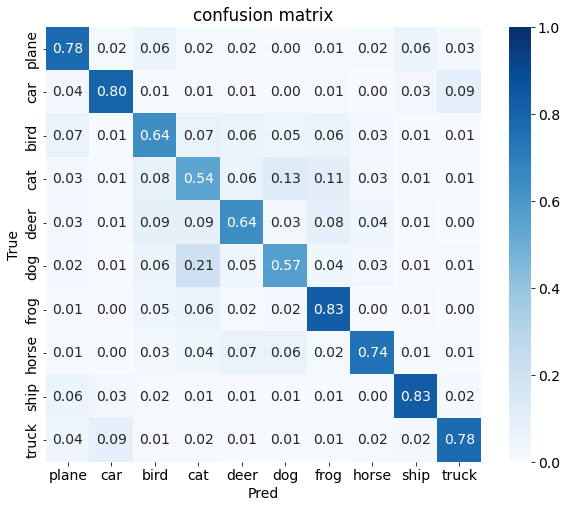

In [ ]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,8))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

### Predictions for Test Data

Anyway let's see predictions for some test data.

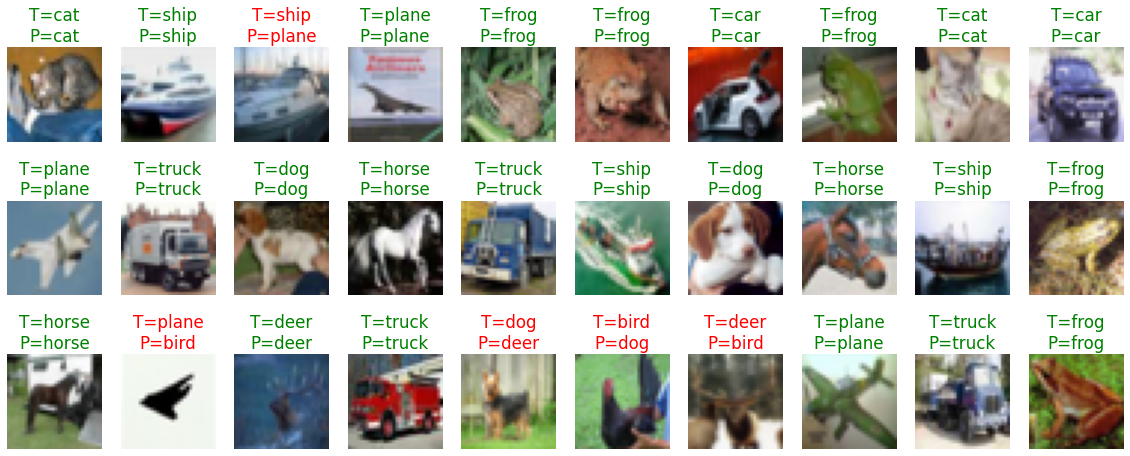

In [ ]:
plt.figure(figsize=(20, 8))

for i in range(30):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))
    plt.subplot(3, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")
